<a href="https://colab.research.google.com/github/guilhermecarva/guilhermecarva/blob/main/Series_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SÉRIES TEMPORAIS

##Vamos estruturar dois modelos de séries temporais, avaliá-los através de alguma métrica. Fazer a previsão do melhor modelo um passo a frente.

Importando as bibliotécas

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Vamos utilizar a série temporal "shampoo", ela é composta por uma série temporal mensal de 3 anos e a quantidade de vendas.

Vamos tratar os dados para utilizar no modelo, alterando os meses que estão enumerados para o formato de data ( ano-mês ). Indexar a coluna data.

In [ ]:
def parser(x):
	return datetime.strptime('202'+x, '%Y-%m')

In [ ]:
data = pd.read_csv('shampoo.csv', index_col=0, header=0, parse_dates=True , date_parser=parser)

In [ ]:
data.index = data.index.to_period('M')
data.tail()

,Sales
Month,
2023-08,407.6
2023-09,682.0
2023-10,475.3
2023-11,581.3
2023-12,646.9


In [ ]:
data.dtypes

Sales    float64
dtype: object

<Axes: xlabel='Month'>

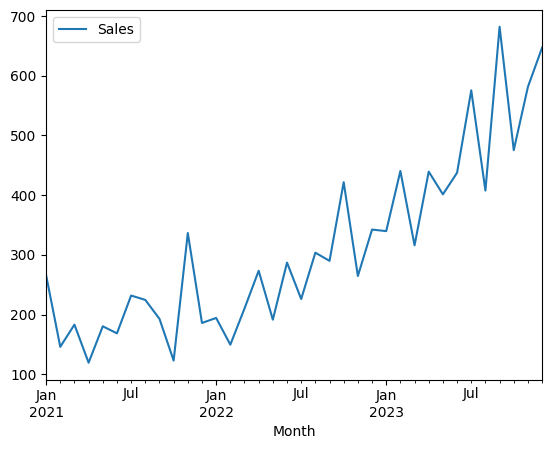

In [ ]:
data.plot()

Importando as bibliotéca de séries temporais ARIMA e as que utilizaremos como métrica.

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

Vamos dividir nosso dataset, alocando 80% para treino.

In [ ]:
X = data.values
size = int(len(X) * 0.8)
X_train, X_test = X[0:size], X[size:len(X)]

In [ ]:
X_train.shape

(28, 1)

Definindo nosso primeiro modelo ( ARIMA ), que é uma integração do modelo AR (autoregressão (p)) e MA (média móvel (q)). Utilizaremos diferença (d) = 0

In [ ]:
def ARMA_model_generation(ts, p, q):
    model = ARIMA(ts, order = [p, 0, q])
    model_fit = model.fit()
    return model_fit

"Fitando" o dataset de treino com grau 1

In [ ]:
ARMA = ARMA_model_generation(X_train, 1, 1)

In [ ]:
ARMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   28
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -158.817
Date:                Sun, 05 Nov 2023   AIC                            325.633
Time:                        23:44:51   BIC                            330.962
Sample:                             0   HQIC                           327.262
                                 - 28                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        273.3003    107.326      2.546      0.011      62.945     483.656
ar.L1          0.9492      0.134      7.093      0.000       0.687       1.212
ma.L1         -0.6335      0.320     -1.979      0.048      -1.261      -0.006
sigma2      4773.9918   1496.770      3.190      0.001    1840.376    7707.607
===================================================================================
Ljung-Box (L1) (Q):                   1.21   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.27   Prob(JB):                         0.56
Heteroskedasticity (H):               2.42   Skew:                             0.43
Prob(H) (two-sided):                  0.20   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

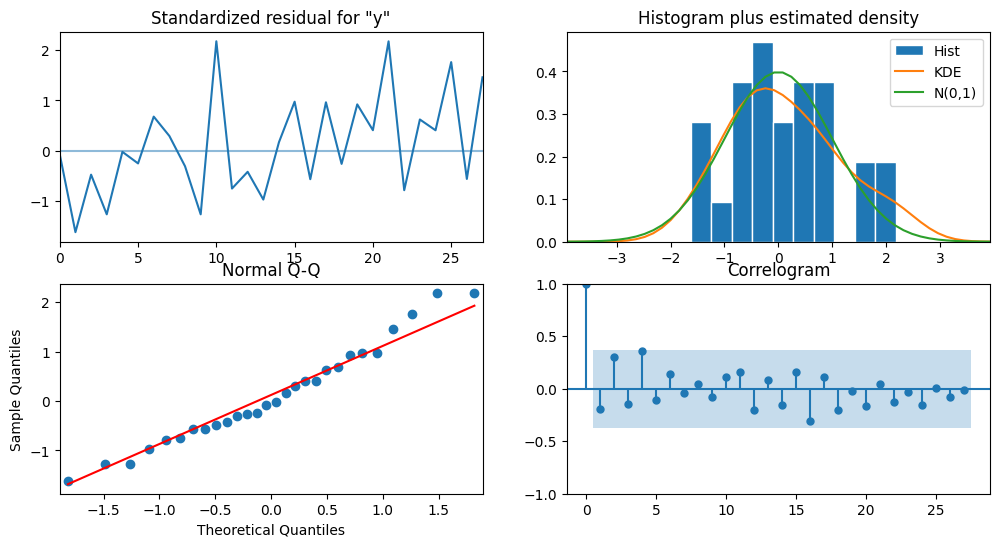

In [ ]:
fig = plt.figure(figsize=(12,6))
fig = ARMA.plot_diagnostics(fig=fig, lags=len(X_train)-1)

Plotando os diagnósticos podemos observar que o correlograma esta bem definido e se encontra dentro dos limites. Os demais gráficos não mostram nenhuma anormalidade.

Ainda não escolhemos o melhor modelo, no entanto, para fins educacionais vamos rodar um loop para "fitar" o modelo (treino), fazer as predições(teste) e  printar as predições e os valores esperados em cada iteração.

Para tanto, após alguns testes, alteramos os parâmetros de p,d e q para (5,1,0)


In [ ]:
history = [x for x in X_train]
predictions = list()

In [ ]:
for t in range(len(X_test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = X_test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=357.645324, expected=401.300000
predicted=443.047835, expected=437.400000
predicted=378.365674, expected=575.500000
predicted=459.415021, expected=407.600000
predicted=526.890876, expected=682.000000
predicted=457.231275, expected=475.300000
predicted=672.914944, expected=581.300000
predicted=531.541449, expected=646.900000


Vamos utilizar duas métricas para futura comparação com o segundo modelo. Serão eles : root mean squared error score (RMSE) e mean absolute error score (MAE)

In [ ]:
rmse = sqrt(mean_squared_error(X_test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 105.813


In [ ]:
mae = mean_absolute_error(X_test, predictions)
print('Test MAE: %.3f' % mae)

Test MAE: 84.800


Podemos verificar visualmente nossas predições em relação ao X_test. Não foram as melhores predições, mas conseguimos identificar a tendência/sazonalidade. A curva vermelha é a predição e a azul o valor esperado.

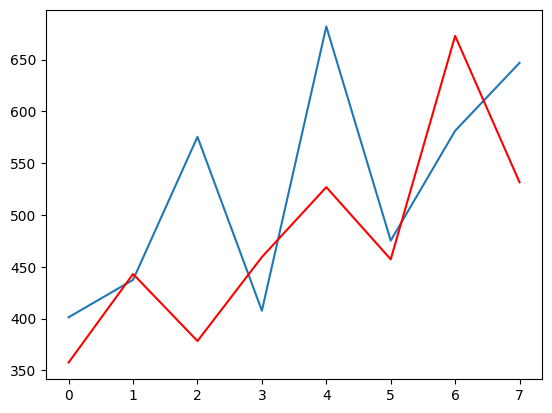

In [ ]:
plt.plot(X_test)
plt.plot(predictions, color='red')
plt.show()

Talvez testando outros parâmetros, poderíamos fazer um fine tuning.

### Para o segundo modelo utilizaremos o Prophet

In [ ]:
import io, os, sys, setuptools, tokenize

In [ ]:
!pip install prophet --quiet
import prophet

In [ ]:
from prophet import Prophet

Teremos de tratar os dados novamente, pois o modelo Prophet necessita que as colunas tenham um nome e tipo específicos.

A coluna com os meses deverá se chamar "ds" e terá o tipo datetime.<br> Já a coluna com as vendas deverá se chamar "y".

In [ ]:
data2 = pd.read_csv('shampoo.csv')

In [ ]:
data2 = data2.rename(columns = {"Month": "ds", 'Sales': "y"}, inplace=False)

In [ ]:
data2['ds'] = data2['ds'].replace(to_replace = ['1-' , '2-' , '3-'] , value = ['2020-' , '2021-' , '2022-'] , regex=True)

In [ ]:
data2['ds'] = pd.to_datetime(data2['ds'], format='%Y/%m')

In [ ]:
data2.head()

,ds,y
0,2020-01-01,266.0
1,2020-02-01,145.9
2,2020-03-01,183.1
3,2020-04-01,119.3
4,2020-05-01,180.3


In [ ]:
data2.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [ ]:
size = int(len(data2) * 0.8)
X_train2, X_test2 = data2[0:size], data2[size:len(X)]

In [ ]:
print(len(X_train2) , len(X_test2))

28 8


In [ ]:
X_train2.tail()

,ds,y
23,2021-12-01,342.3
24,2022-01-01,339.7
25,2022-02-01,440.4
26,2022-03-01,315.9
27,2022-04-01,439.3


Instanciando o modelo Prophet. "Fitando" X_train.

In [ ]:
model2 = Prophet(
    seasonality_mode="multiplicative",
    weekly_seasonality=False,
    daily_seasonality=False,
    yearly_seasonality=True,
)
model2.fit(X_train2)

INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpumfdy1jq/8hxf2f0j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpumfdy1jq/wr_l45ge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64701', 'data', 'file=/tmp/tmpumfdy1jq/8hxf2f0j.json', 'init=/tmp/tmpumfdy1jq/wr_l45ge.json', 'output', 'file=/tmp/tmpumfdy1jq/prophet_model3jtwh6sy/prophet_model-20231105234508.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:45:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:45:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Vamos fazer a predição do nosso dataset de test.

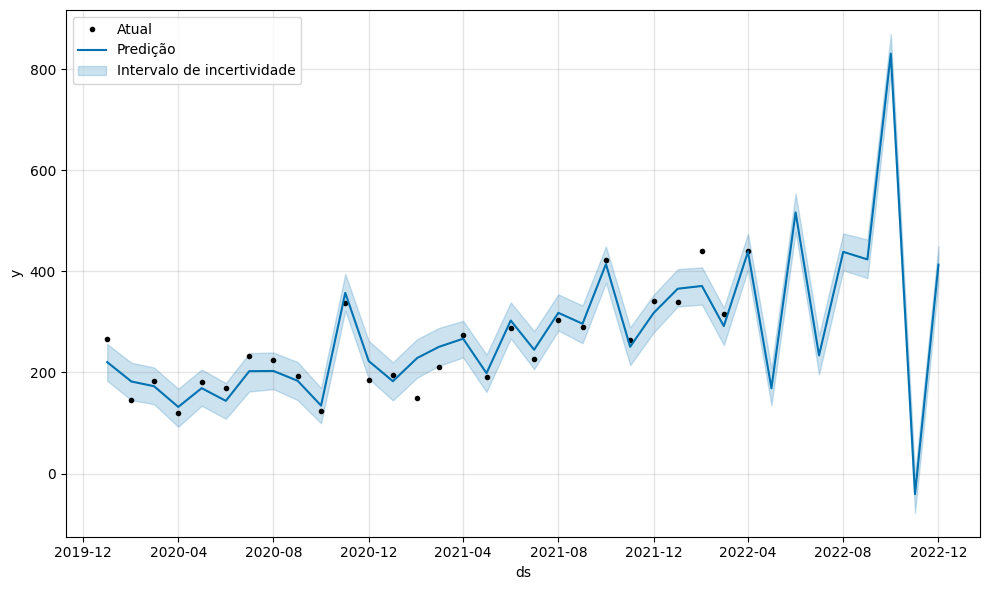

In [ ]:
future = model2.make_future_dataframe(periods=len(X_test2), freq = "MS")
forecast = model2.predict(future)
fig1 = model2.plot(forecast)
plt.legend(['Atual', 'Predição', 'Intervalo de incertividade'])
plt.show()

In [ ]:
forecast.tail(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
34,2022-11-01,471.185451,-77.393877,-2.382358,471.160116,471.211786,-1.085973,-1.085973,-1.085973,-1.085973,-1.085973,-1.085973,0.0,0.0,0.0,-40.509232
35,2022-12-01,480.681185,377.731416,450.086614,480.651123,480.713004,-0.140260,-0.140260,-0.140260,-0.140260,-0.140260,-0.140260,0.0,0.0,0.0,413.260776


In [ ]:
print(len(X_test2.y), len(forecast.yhat))

8 36


Vamos considerar apenas as última predições para termos o mesmo tamanho de datasets (teste e predições) para calcularmos os scores

In [ ]:
pred = forecast.iloc[-len(X_test2):]['yhat']
pred

28    168.820644
29    516.494585
30    233.740134
31    438.511253
32    423.561186
33    830.480085
34    -40.509232
35    413.260776
Name: yhat, dtype: float64

In [ ]:
rmse = sqrt(mean_squared_error(X_test2.y, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 318.637


In [ ]:
mae = mean_absolute_error(X_test2.y, pred)
print('Test MAE: %.3f' % mae)

Test MAE: 269.164


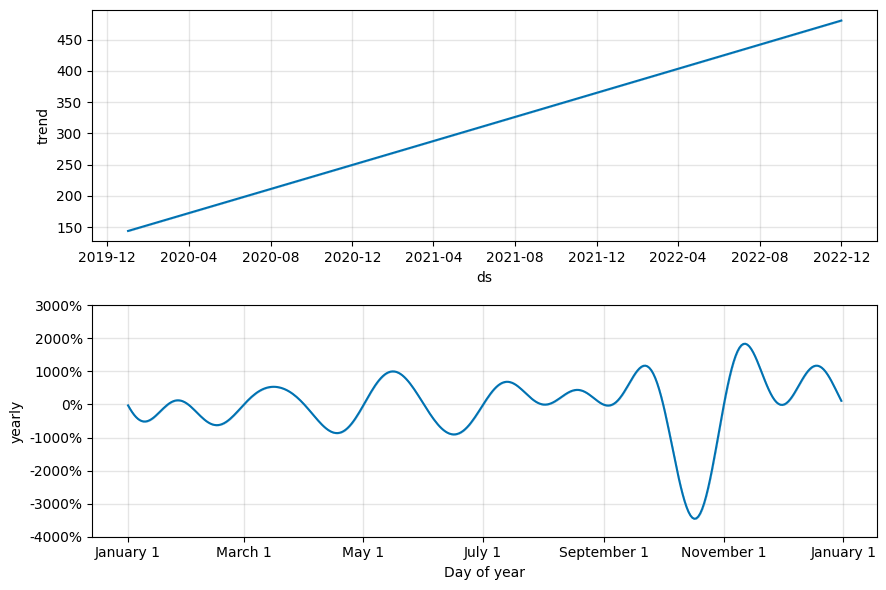

In [ ]:
fig2 = model2.plot_components(forecast)

Podemos verificar que não temos oscilação na tendência e a sazonalidade anual possui uma variação maior no mês de outubro.

### Agora que temos as métricas de ambos os modelo, podemos concluir que o primeiro modelo se saiu melhor. então vamos prever 1 passo adiante utilizando o modelo ARIMA

In [ ]:
forecast_1_passo = model_fit.forecast(1)
print(data.tail(3),forecast_1_passo)

         Sales  forecast_manual
Month                          
2023-10  475.3       582.216231
2023-11  581.3       521.458371
2023-12  646.9       592.324672 [531.54144889]


Para termos uma melhor visualização gráfica, vamos utilizar mais períodos na predição

<Axes: xlabel='Month'>

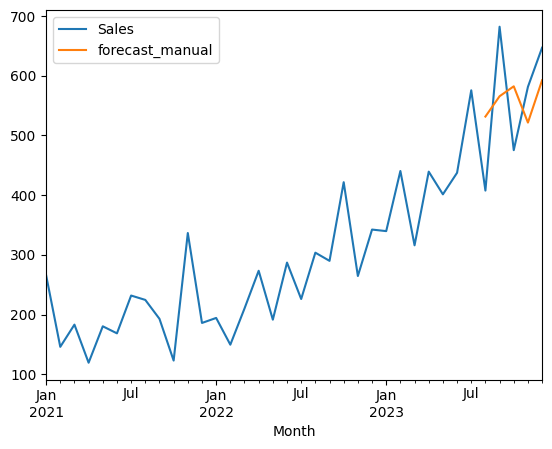

In [ ]:
forecast_1_passo = model_fit.forecast(5)
data['forecast_manual'] = [None]*(len(data)-len(forecast_1_passo)) + list(forecast_1_passo)
data.plot()

A predição ficou na média do valor esperado